## Frequentist approaches
#### Chi square test in A/B testing
This test is used when:
* all values in a table are greater than 5, i.e., since the chi square test is a sum of normal distributions, the sample is large enough to assume the normality (has to do with central limit theorem), and the total sample size is at least 30
* data is categorical &
* we need to determine if:
    * two experiments turned out completely independent from each other and there is no real difference between two (50/50 distribution of a metric (or a group of features))
    * the level of fairness between two experiments is uneven and there might be positive/negative lift between A and B tests
###### [(c) source](https://www.youtube.com/watch?v=NTHA9Qa81R8)

#### A/B testing for categorical data (chi square independence test)
For the case of categorical data we carry out Chi-squared test (since values are lying within 0 and 1 (or at least can be normalized) and chi2 is a sum of standard normal dists squared): $\chi_{stat}=\sum_{i=1}^k\frac{(\text{observed}_i-\text{expected}_i)^2}{\text{expected}_i}$, where $i$ is calculated over each group over each experiment. Let's assume there're two groups and three metrics provided. This will be **observed data**:

In [95]:
import polars as pl
import numpy as np

metric_keys = ['comments','likes','views']
groupA, groupB = np.random.randint(50,600,(len(metric_keys),1)), \
    np.random.randint(50,600,(len(metric_keys),1))
ab_testing_data = np.hstack([groupA,groupB])
ab_testing_data = np.concatenate((ab_testing_data,
    ab_testing_data.sum(axis=1).reshape(-1,1)),axis=1)

df = pl.DataFrame(
    ab_testing_data,
    schema=['A', 'B', 'total']
)
df = df.with_columns(pl.col("*").exclude("key")\
    .cast(pl.Int32, strict=False))
df.head()

A,B,total
i32,i32,i32
315,302,617
295,480,775
348,167,515


We assume that groups are independent enough. In this case we can apply the probability formula that joint probability is equal to multiplication of the two, i.e. we treat each metric as a frequency between two groups. This way we form **expected data** (A and comments are independent e.t.c. ...):
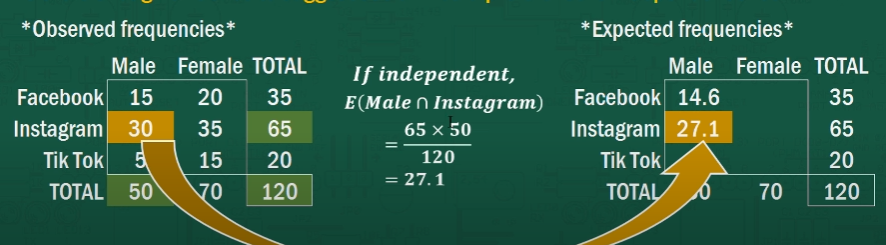

In [105]:
totalOverCat = ab_testing_data.sum(axis=1)
totalOverMetrics = df.get_column('total').to_numpy()
expected_frequencies = df.get_column('total').to_numpy().reshape(-1,1) @ \
    totalOverCat[:-1].reshape(1,-1)

df_expected = pl.DataFrame(
    expected_frequencies / totalOverCat[-1]
)
df_expected

column_0,column_1
f64,f64
739.201942,928.495146
928.495146,1166.262136
617.0,775.0


Now we have two hypotheses:
* $H_0$: metrics do not depend on the A/B change
* $H_1$: there's dependence between metrics and A/B change

Now we calculate test statistic $\chi^2$ with $df=(rows-1)\times (cols-1)$.

**Degrees of freedom** - pieces of independent information needed to fill table of data (https://youtu.be/NTHA9Qa81R8?t=791)

In [125]:
chiStat = (
    (df_expected - df.select(['A','B'])).to_numpy() ** 2 \
        / df_expected
).sum()
chiStat

2096.4604522370046

In [131]:
import scipy.stats as st
alpha = .05
dof = (df_expected.shape[0]-1) * \
    (df_expected.shape[1]-1)

# we reject null hypotheses 
# if statistic is greater than 5.99 (95% of values)
st.chi2.ppf(1-alpha, df=dof), st.chi2.sf(chiStat, dof)

(5.991464547107979, 0.0)

#### T-test in AB testing
T-test is also a part of the frequentist approach to A/B testing. We use use it when:
* We need to compare significance in difference between distributions by their difference in means
* We deal with raw distributions and there's no need to group data
* Several conditions are met, namely: randomness, approximate normality (that sampled mean should follow, which it usually does due to CLT) and independence (rule of thumb - we should sample not more than $10\%$ in order to ensure independence).

Given this test, we lay out 2 hypotheses:
* $H_0$: $\mu_A=\mu_B$
* $H_1$: $\mu_A\neq\mu_B$

The test itself tells us how much difference is in units of standard errors. That means that the more users are sampled in each group and the bigger the difference between two -> the bigger the two-sample t-statistic: $\frac{\mu_A-\mu_B}{\sqrt{SE_A^2+SE_B^2}}$, where $SE=\frac{\sigma}{\sqrt{n}}$, i.e. the uncertainty around the mean, which measures variability between two distinct samples, which could also account to variance around the mean:

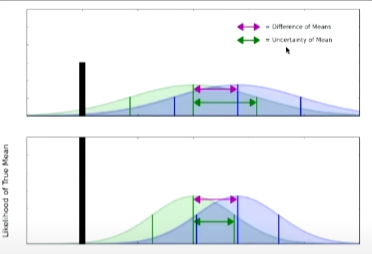

In [1]:
import numpy as np
import polars as pl

N = 500
cvr = pl.DataFrame(
    {'A': np.random.randint(100,5000,(N,)), 
     'B': np.random.randint(100,5000,(N,))}
) # A/B testing for conversion rate (CVR)
cvr.head(2)

A,B
i32,i32
4485,3320
2630,1968


In [2]:
cvr.plot.kde()

:NdOverlay   [Variable]
   :Distribution   [value]   (Density)

In [4]:
t_stat = (cvr.mean(axis=0).with_columns(
        (pl.col('A')-pl.col('B')).alias('mean_diff')
    ).select('mean_diff') / \
        cvr.var().with_columns(
            ((pl.col('A') / N + pl.col('B') / N)**.5).alias('ind_se')
        ).select('ind_se')).to_numpy().flatten()
t_stat[0]

C:\Users\user\AppData\Local\Temp\ipykernel_92540\1100820315.py:1: DeprecationWarning: The `axis` parameter for `DataFrame.mean` is deprecated. Use `DataFrame.mean_horizontal()` to perform horizontal aggregation.
  t_stat = (cvr.mean(axis=0).with_columns(


0.2600575559051383

In [5]:
import scipy.stats as st
alpha = .05

# Min(N_A,N_B)-1 traditionally speaking (where DOF is basically an
# approximation for variance)
dof = min(N, N)-1 

t_crit = st.t.ppf(1-alpha, df=dof)

# since t's follow a normal dist it's going to be a two-tailed test
p_value = 2*(1-st.t.cdf(t_stat,df=dof))[0]

print(f'Statistic vs critical: {t_stat[0]} :: {t_crit}',
      f'\np_value :: {p_value}')

Statistic vs critical: 0.2600575559051383 :: 1.647912984059706 
p_value :: 0.7949266450181034


In [6]:
# comparing with scipy

t_statistic, p_value = st.ttest_ind(cvr.select('A'), cvr.select('B'), 
                                    equal_var=False)
print(f'Scipy statistic & p_value :: {t_statistic}, {p_value}')

Scipy statistic & p_value :: [0.26005756], [0.79487302]


## Bayesian approach
> ###### This approach is quite challenging to comprehend, so there'll sometimes be references to jupyter cells supporting particular statements. These references will be denoted as `[reference N]`

Via bayesian framework we can get more interpretable results, rather than critical values and p values, namely:
* Actual probability of $P(A\geq B)$ or $P(B\geq A)$
* Confidence intervals

In bayesian-based testing we can deal with continuos data of any type, namely:
* data of binary outcomes (e.g. conversion rate)
* continuos data of various outcomes (e.g. retention rate)

#### How does it work
Bayesian A/B testing is based upon a classical Bayesian formula: $P(H|d)=\frac{P(d|H)\times P(H)}{P(d)}$, where:
* $H$ - general tested hypothesis that we want to know the probability of and which we put into the **posterior**. In classical bayesian inference this would be some distrubtion parameter $\theta$ (or a set of parameters) that we want to get to know better, while in the case of CVR it could be a true conversion rate
* $d$ - data
* $P(H|d)$ - **posterior**. The distribution of all possible values of $H$ given the observed data. In the binary case it is the distribution of all possible $p_A$ and $p_B$ under the given data, which is the probability parameter of user's conversion. Therefore, knowing approximate distribution of parameters we can finally conventionally estimate the $P(A > B)$ or $P(p_A > p_B)$, which we couldn't do in the frequentist approach
* $P(d|H)$ - **likelihood**. This yields the probability of getting the data we observed ($d$) given a particular element from the set of possible estimates $H$
* $P(H)$ - **prior**. Abstract knowledge of the outcome of the tested hypothesis, before conducting the experiment (e.g. we know that current CVR is around $5\%$ and very high CVR's  of, for instance, $20\%$ or more are unlikely (we might even know the variance). Therefore we choose $B(3, 50)$ distribution as our prior, which "empirically" depicts this knowledge the best. In A/B testing, having no justifiable info on the B, we assume that A and B have the same prior. Prior can be changed, which is one of the reasons people use Bayesian approach, as their ideas can be challenged and, as a result, improved upon)
* $P(d)$ - **evidence**. Defined by the integral over a space of all possible $H$: $\int_H P(D|H)\times P(H)dH$. This yields the probability of generating an observed sample given the prior $P(H)$ we've suggested earlier

#### Binary event (CVR)
1) Assume we have binary CVR values for each group: $d_A$ and $d_B$. Given this data we can get the $p_A$ and $p_B$. Although, since we're dealing with a Bayes framework we'll treat them as continuos values. Therefore we get the following equation for the likelihood: $P(d|H)=P\left(\mathbf{d}_A, \mathbf{d}_B \mid p_A, p_B\right)=P\left(\mathbf{d}_A \mid p_A\right) P\left(\mathbf{d}_B \mid p_B\right)=p_A^{c_A}\left(1-p_A\right)^{n_A-c_A} p_B^{c_B}\left(1-p_B\right)^{n_B-c_B}$, where $c_A$ and $c_B$ are numbers of successes for each group $(C\text{onversions})$
2) We assume an uninformative prior or, as an extreme baseline, a flat (uniform dist) prior. For the binary case a rule of thumb is the Beta distribution $B(\alpha, \beta)$ with a pdf of $f(x ; \alpha, \beta)=\frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}$ with $B(\alpha, \beta)$ being a $[0,1]$ normalizing constant. Intuitively, it means that the higher the size of the sample is, the more certain we are about $x$ `[reference 1]`. It also satisfies several assumptions regarding CVR, including $x\in[0,1]$. Note that in this case $x=p_A$ or $p_B$ and that are continuos for each independent group
3) Now we do a little trick to get rid of $B(\alpha, \beta)$ and $P(d)$. Both of them are constants, therefore we can get rid of them by saying that our posterior $P(H|d)\propto P(d|H)\times P(H)$ (proportional to the product).Technically, we would be just scaling the posterior distribution by the same factor both for A and B groups, which we can omit and, therefore, for one group A the posterior will look like $P(H|d)\propto (p_A^{c_A}\left(1-p_A\right)^{n_A-c_A})\times(p_A^{\alpha_A-1}(1-p_A)^{\beta_A-1})=p_A^{\alpha_A+c_A-1}\times(1-p_A)^{(n_A-c_A)+\beta_A-1}$. Since we are operating with proportions, we can then normalize the current posterior by $B(\alpha_A+c_A, (n_A-c_A)+\beta_A)$ to make our posterior be proportionate to the new Beta distribution: $P(H|d)\propto Beta(\alpha_A+c_A, (n_A-c_A)+\beta_A)= Beta(\alpha_A+\text{conversions}, \beta_A+\text{non-conversions})$
4) After deriving a formula for an interpretable impact over the posterior we should choose the most fit prior. We know that the general one is the Beta prior, but now we need to know how to scale both $\alpha$ and $\beta$ to best match our knowledge. We could do that by looking at previous campaign performance. E.g. considering an average CVR $\mu$ was around $10\%$ we would scale $\alpha$ and $\beta$ of the worst prior $B(1,1)$ (uniform dist) by $\mu\times\text{scaler}$ and $(1-\mu)\times\text{scaler}$ accordingly. $\text{scaler}$ in this case could be a value from $[1,100]$ which would define the certainty of getting this previous knowledge of CVR again. After that we are finally able to collect samples for each group and calculate probabilities. For example we can do that by bootstraping and getting a fraction of either $A<B$ or otherwise
5) We then sample from each of the two posterior distributions until some decision rule is satisfied. This decision rule is also needed to determine when to stop the A/B test. We could apply a standard T-test or something more challenging like the expected loss method

In [1]:
# random A/B samples for CVR's 
import numpy as np

# n=1 in binomial, therefore it's bernoulli
cvr_a, cvr_b = np.random.binomial(1,.3, 1000), \
    np.random.binomial(1,.7, 1000)
cvr_a[:10], cvr_b[:10]

(array([1, 0, 1, 1, 1, 0, 0, 0, 0, 1]), array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0]))

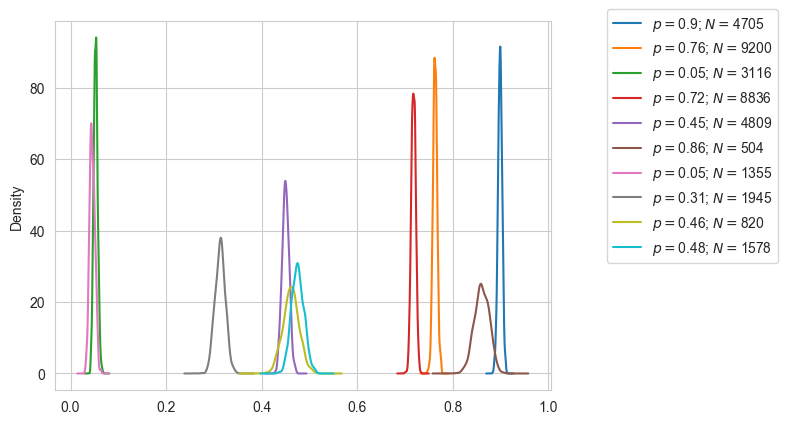

In [30]:
# REFERENCE 1
# how do CVR+N affect the Beta uninformative prior?

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# N and CVR are randomized
df = pd.DataFrame({
    'N': np.random.randint(100, 10_000, 10)
})
df['convs'] = np.random.randint(10,df['N'])
df['fails'] = -df['convs'] + df['N']

sns.set_style('whitegrid')
arrays = []
for i in range(1000):
    arrays.append(np.random.beta(df[['convs']]+1,df[['fails']]+1))
dist_df = pd.DataFrame(np.hstack(arrays)).T
dist_df.columns = ['$p=$'+str(round(c[1] / c[0], 2))+'; $N=$'+str(c[0]) for c in df.values]
dist_df.plot(kind='kde')
plt.legend(bbox_to_anchor=(1.1, 1.05))